In [6]:
# =========================================
# Primera celda — Importaciones y estilo
# =========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import joblib

sns.set(style="whitegrid")
print("Librerías cargadas.")



Librerías cargadas.


In [7]:
# ==============================
# Segunda celda - Carga de datos
# ==============================
datos = pd.read_csv("C:/RespaldoDB/comprar_alquilar.csv")
datos.head()


,ingresos,gastos_comunes,pago_coche,gastos_otros,ahorros,vivienda,estado_civil,hijos,trabajo,comprar
0,6000,1000,0,600,50000,400000,0,2,2,1
1,6745,944,123,429,43240,636897,1,3,6,0
2,6455,1033,98,795,57463,321779,2,1,8,1
3,7098,1278,15,254,54506,660933,0,0,3,0
4,6167,863,223,520,41512,348932,0,0,3,1


In [8]:
# =========================================
# Justificación del algoritmo (REPORTE)
# =========================================
"""
Justificación del algoritmo
---------------------------
Se emplea PCA (Análisis de Componentes Principales) para:
- Decorrelacionar variables numéricas y ordenar la información por importancia (varianza).
- Explorar la estructura interna y facilitar visualizaciones.
- Conservar exactamente el 100% de la varianza, tal como se solicita. Nota: esto implica
  no reducir dimensionalidad (el número de componentes será igual al número de variables
  numéricas usadas). Aun así, el espacio transformado es útil como representación ortogonal
  y para comprender la contribución de cada componente.

Descripción del diseño del modelo
---------------------------------
1) Preprocesamiento:
   - Selección de variables predictoras numéricas (todas menos la etiqueta 'comprar').
   - Imputación de valores faltantes con la media (SimpleImputer), por robustez.
   - Estandarización (StandardScaler) para que PCA no se sesgue por escalas distintas.

2) PCA:
   - Se calcula PCA y se obtiene la curva de varianza acumulada.
   - Se escoge el número mínimo de componentes necesarias para alcanzar 100% de varianza.
     (En la práctica, coincide con todas las variables: no hay reducción, pero sí rotación).

Evaluación y optimización del modelo
------------------------------------
- Métrica: varianza explicada por componente y varianza acumulada.
- "Optimización": el umbral de varianza se fija en 100% (1.0), cumpliendo el requerimiento.
  Para escenarios reales se recomienda 95%-99% para reducir dimensionalidad con mínima pérdida.

Enlace a repositorio
--------------------
Define 'repo_url' abajo con el enlace a tu repositorio (GitHub/GitLab) donde subas:
- Este notebook
- comprar_alquilar.csv
- modelo_pca_comprar_alquilar.pkl
- scaler_comprar_alquilar.pkl
"""



'\nJustificación del algoritmo\n---------------------------\nSe emplea PCA (Análisis de Componentes Principales) para:\n- Decorrelacionar variables numéricas y ordenar la información por importancia (varianza).\n- Explorar la estructura interna y facilitar visualizaciones.\n- Conservar exactamente el 100% de la varianza, tal como se solicita. Nota: esto implica\n  no reducir dimensionalidad (el número de componentes será igual al número de variables\n  numéricas usadas). Aun así, el espacio transformado es útil como representación ortogonal\n  y para comprender la contribución de cada componente.\n\nDescripción del diseño del modelo\n---------------------------------\n1) Preprocesamiento:\n   - Selección de variables predictoras numéricas (todas menos la etiqueta \'comprar\').\n   - Imputación de valores faltantes con la media (SimpleImputer), por robustez.\n   - Estandarización (StandardScaler) para que PCA no se sesgue por escalas distintas.\n\n2) PCA:\n   - Se calcula PCA y se obtie

In [9]:
# =========================================
# Preprocesamiento
# =========================================
# Excluimos la etiqueta 'comprar' si existe
cols = [c for c in datos.columns if c != 'comprar']
X = datos[cols].copy()

# Si hay columnas no numéricas, intenta convertirlas o elimínalas explícitamente
# (en tu ejemplo parecen ser numéricas ya codificadas)
X = X.apply(pd.to_numeric, errors='coerce')

# Imputación y escalado
imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()

X_imp = imputer.fit_transform(X)
X_scaled = scaler.fit_transform(X_imp)

print("Variables usadas:", X.columns.tolist())
print("Shape tras imputación y escalado:", X_scaled.shape)



Variables usadas: ['ingresos', 'gastos_comunes', 'pago_coche', 'gastos_otros', 'ahorros', 'vivienda', 'estado_civil', 'hijos', 'trabajo']
Shape tras imputación y escalado: (202, 9)


In [11]:
# =========================================
# PCA con 100% de varianza
# =========================================
# Primero ajustamos PCA completo para ver la varianza explicada por cada componente
pca_full = PCA(n_components=None)
pca_full.fit(X_scaled)

var_ratio = pca_full.explained_variance_ratio_
cum_var = np.cumsum(var_ratio)

# Umbral de varianza solicitado: 100%
umbral_varianza = 1.0
# Número máximo de componentes posibles
n_max = min(X_scaled.shape)

# Número necesario para llegar al 100% de varianza acumulada
n_componentes_opt = int(np.searchsorted(cum_var, umbral_varianza) + 1)

# Ajustamos al límite máximo permitido
n_componentes_opt = min(n_componentes_opt, n_max)

print("Número final de componentes usados:", n_componentes_opt)


# Ajustamos PCA final con el número de componentes necesarios (serán todas)
pca = PCA(n_components=n_componentes_opt)
X_pca = pca.fit_transform(X_scaled)

print(f"Componentes seleccionadas para {umbral_varianza*100:.0f}% de varianza:", n_componentes_opt)
print("Varianza explicada por componente:", np.round(pca.explained_variance_ratio_, 4))
print("Varianza acumulada:", np.round(np.cumsum(pca.explained_variance_ratio_), 4))


Número final de componentes usados: 9
Componentes seleccionadas para 100% de varianza: 9
Varianza explicada por componente: [0.2991 0.2329 0.1171 0.1069 0.0964 0.0563 0.0415 0.0302 0.0197]
Varianza acumulada: [0.2991 0.5321 0.6492 0.7561 0.8524 0.9087 0.9502 0.9803 1.    ]


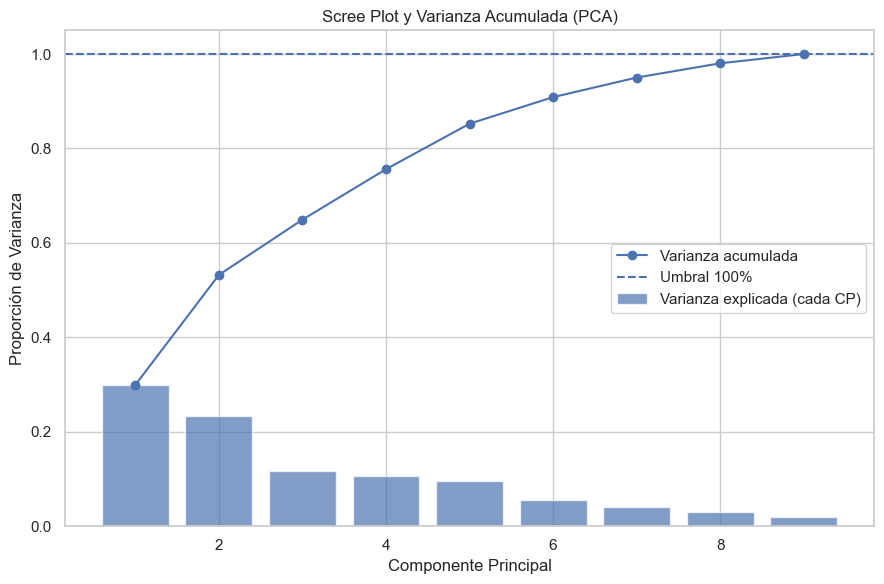

'\nInterpretación de la gráfica\n----------------------------\n- Las barras muestran cuánta varianza aporta cada componente.\n- La curva acumulada alcanza 1.0 (100%) en la última componente, lo que confirma que,\n  para no perder información (varianza), necesitamos conservar todas las componentes.\n- Aunque no hay reducción, la descomposición en componentes principales sigue siendo útil\n  para análisis exploratorio, detección de redundancias y preparación de pasos posteriores\n  (p.ej., si más adelante decides trabajar con 95%-99% de varianza).\n'

In [12]:
# =========================================
# Gráfica personalizada — Scree + Varianza acumulada
# =========================================
plt.figure(figsize=(9,6))
indices = np.arange(1, len(var_ratio)+1)

# Scree plot (barras)
plt.bar(indices, var_ratio, alpha=0.7, label='Varianza explicada (cada CP)')

# Curva acumulada
plt.plot(indices, cum_var, marker='o', label='Varianza acumulada')

# Línea del umbral (100%)
plt.axhline(umbral_varianza, linestyle='--', label=f'Umbral {int(umbral_varianza*100)}%')

plt.xlabel('Componente Principal')
plt.ylabel('Proporción de Varianza')
plt.title('Scree Plot y Varianza Acumulada (PCA)')
plt.legend()
plt.tight_layout()
plt.show()

"""
Interpretación de la gráfica
----------------------------
- Las barras muestran cuánta varianza aporta cada componente.
- La curva acumulada alcanza 1.0 (100%) en la última componente, lo que confirma que,
  para no perder información (varianza), necesitamos conservar todas las componentes.
- Aunque no hay reducción, la descomposición en componentes principales sigue siendo útil
  para análisis exploratorio, detección de redundancias y preparación de pasos posteriores
  (p.ej., si más adelante decides trabajar con 95%-99% de varianza).
"""


In [14]:
# ==============================
# Guardar modelo y escalador
# ==============================
joblib.dump(pca, "modelo_pca_comprar_alquilar.pkl")
joblib.dump(scaler, "scaler_comprar_alquilar.pkl")
print("Modelo PCA y escalador guardados.")


Modelo PCA y escalador guardados.
